# HST TinyTim PSF reconstruction 

This notebook demonstrates how the PSF can be recovered from star cutouts. 
It requires [Photutils](https://photutils.readthedocs.io/en/stable/psf.html) and [PSFr](https://github.com/sibirrer/psfr) for comparison. 

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib as mplimport
import scipy.ndimage
import pickle as pkl
from starred.utils.generic_utils import make_grid, gaussian_function, save_fits, Downsample, Upsample
import time, glob, os

# Generate Mock data from TinyTim PSF
First, we generate cutout of stars from the 10-times supersampled PSF, provided by [TinyTim](https://www.stsci.edu/hst/instrumentation/focus-and-pointing/focus/tiny-tim-hst-psf-modeling).
Resolution is 0.04" per pixel.  

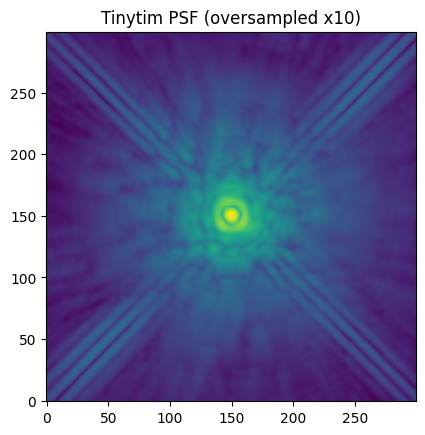

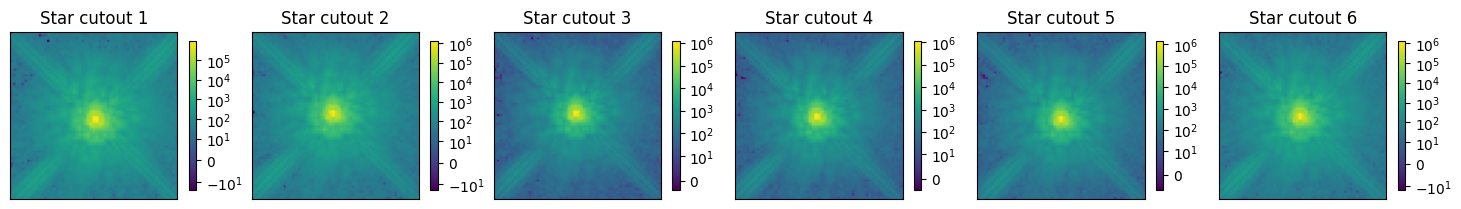

In [2]:
instrument = 'tinytim10'
pathPSF = './data/6_data/PSF/psf_%s.fits'%instrument
SNRs = [800000]
test_dir = './data/6_data/star_cutouts'
upsampling_factor = 10
final_res_factor = 2 # to the drizzled resolution (0.04")    
n_star = 6
noise = 10 #level of background noise, arbitrary

shift_sigma = 1 # in the unit of pixel, of the final image (low resolution)
interpolation_order = 1 #use linear interpolation
np.random.seed(123)

PSF = fits.open(pathPSF)[0].data
PSF /= np.sum(PSF)
stars=[]
noise_maps = []
for SNR in SNRs:
    # simulated image are in e-
    amp = np.ones(n_star) * noise * SNR
    skylevel = 0 # we assume that the sky is properly subtracted
    plot = False

    for i in range(n_star):
        # shift_x = 0.
        shift_x = np.random.normal(loc=0, scale=(shift_sigma*upsampling_factor) /final_res_factor)
        # shift_y = 0.
        shift_y = np.random.normal(loc=0, scale=(shift_sigma*upsampling_factor) /final_res_factor)
        PSF_shifted = PSF
        size_PSF, _ = np.shape(PSF_shifted)
        PSF_shifted = scipy.ndimage.shift(PSF, (shift_x,shift_y), output=None, order=interpolation_order, mode='nearest')
        PSF_shifted = Downsample(PSF_shifted, factor=upsampling_factor/final_res_factor) #downsample by a factor 5 

        if instrument == 'tinytim10': # tinytim PSF is centered in the middle of the 151th pixel, apply 1 pixel shift to match STARRED convention
            PSF_shifted = PSF_shifted[1::,1::]

        nx_im, ny_im = np.shape(PSF_shifted)
        PSF_shifted /= np.sum(PSF_shifted) #renormalise one more time

        star = amp[i] * PSF_shifted

        poisson_noise = np.sqrt(np.abs(star)) * np.random.randn(nx_im, ny_im)
        background = np.random.normal(loc=skylevel, scale=noise, size=(nx_im, ny_im))
        noise_map = np.sqrt(np.abs(star)) + noise
        star = star + background + poisson_noise
        stars.append(star)
        noise_maps.append(noise_map)

        hdu = fits.PrimaryHDU(star)
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(test_dir, 'stars', 'star_%i.fits'%(i)), overwrite=True)

        hdu = fits.PrimaryHDU(noise_map)
        hdul = fits.HDUList([hdu])
        hdul.writeto(os.path.join(test_dir, 'noise_maps', 'noise_map_%i.fits'%(i)), overwrite=True)

plt.figure(1)
plt.title('Tinytim PSF (oversampled x10)')
plt.imshow(np.log10(PSF), origin='lower')
plt.show()


fig2, axes = plt.subplots(1,n_star, figsize=(18,8))
plt.subplots_adjust(wspace=0.3)
for i,ax in enumerate(axes): 
    ax.set_title('Star cutout %i'%(i+1))
    fig2.colorbar(ax.imshow(stars[i], norm=colors.SymLogNorm(linthresh=10), origin='lower'),
                     ax=ax,
                     fraction=0.04, pad=0.06)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

# PSF reconstruction with STARRED

In this example, we will call the script `1_generate_psf.py`, which run a 2 steps PSF reconstruction, first by fitting a Moffat and then refining with this fit with regularized gird of pixel.
Results (fits file and plots) are saved in the `outputpath` directory. At high-SNR (SNR > 100000), `lambda_hf` could be decreased a bit (e.g. `lambda_hf=0.3`) to better reconstruct the high-frequency features contained in the diffraction spikes of the PSF. 

In [3]:
lambda_scale = 2.
lambda_hf = 2.
niter = 1000
subsampling = 3
learning_rate = 1e-2
noise_method = 'MC'

file_to_run = '../../scripts/1_generate_psf.py'

datapath = os.path.abspath(os.path.join(test_dir, 'stars'))
noise_path = os.path.abspath(os.path.join(test_dir, 'noise_maps'))
outputpath = os.path.abspath('./output_PSF_HST')

if not os.path.isdir(outputpath):
    os.mkdir(outputpath)

argument = '--data-path %s --output-path %s '%(datapath,outputpath)
argument += '--lambda-scales %2.2e '%lambda_scale
argument += '--lambda-hf %2.2e '%lambda_hf
argument += '--niter %i '%niter
argument += '--subsampling-factor %i '%subsampling
argument += '--noise-map-path %s '%noise_path
argument += '--method-noise %s '%noise_method
argument += '--float64 '
argument += '--init-learning-rate %2.2e '%learning_rate
argument += '--optim-analytical Newton-CG '


start_time = time.time()
cmd = 'python3 %s %s'%(file_to_run, argument)
print(cmd)
os.system('python3 %s %s'%(file_to_run, argument))
print('Running in %2.2f seconds'%(time.time() - start_time))

python3 ../../scripts/1_generate_psf.py --data-path /Users/martin/Desktop/modules/starred/notebooks/more_examples/data/6_data/star_cutouts/stars --output-path /Users/martin/Desktop/modules/starred/notebooks/more_examples/output_PSF_HST --lambda-scales 2.00e+00 --lambda-hf 2.00e+00 --niter 1000 --subsampling-factor 3 --noise-map-path /Users/martin/Desktop/modules/starred/notebooks/more_examples/data/6_data/star_cutouts/noise_maps --method-noise MC --float64 --init-learning-rate 1.00e-02 --optim-analytical Newton-CG 
Enabling float64 computations.
Running joined fit on 6 images...
Found 6 noise maps...
Initial guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 48.29531645930846}, 'kwargs_gaussian': {'a': Array([48.29150639, 48.29275039, 48.30581444, 48.28197972, 48.28865092,
       48.31119691], dtype=float64), 'x0': array([ 0.74384637, -0.87792558, -0.50902498, -0.54004544,  0.1790267 ,
       -0.79291849]), 'y0': array([-1.54648893,  0.4972541 ,  0.52032881, -0.66632046, -1.4103

/Users/martin/Desktop/modules/starred/starred/optim/optimization.py:78: UserWarning: You are using an unconstrained optimiser. Bounds are ignored.
  warnings.warn('You are using an unconstrained optimiser. Bounds are ignored.')


Success of the step 1 fit in 58 iterations (24.369431018829346 s)


/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


Step 1/2 took 24 seconds
Kwargs partial at step 1/2 {'kwargs_moffat': {'fwhm': Array([0.87971479], dtype=float64), 'beta': Array([1.34652757], dtype=float64), 'C': Array([48.29531646], dtype=float64)}, 'kwargs_gaussian': {'a': Array([279.74596539, 285.34842216, 286.12676614, 287.74219966,
       285.88829866, 286.08247235], dtype=float64), 'x0': Array([ 0.58951098, -1.04824653, -0.63622951, -0.66232051,  0.03524557,
       -0.95355466], dtype=float64), 'y0': Array([-1.52187533,  0.56601323,  0.57123126, -0.59784131, -1.3750745 ,
       -0.44023307], dtype=float64)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}
LogL :  3107443.175959805
Overall Reduced Chi2 :  297.5623073790869
### Step 2, fixing : ['moffat'] ###


optax.adabelief: 100%|██████████| 1000/1000 [00:30<00:00, 32.39it/s]


Step 2/2 took 31 seconds
Kwargs partial at step 2/2 {'kwargs_moffat': {'fwhm': Array([0.87971479], dtype=float64), 'beta': Array([1.34652757], dtype=float64), 'C': Array([48.29531646], dtype=float64)}, 'kwargs_gaussian': {'a': Array([288.00939111, 288.14032953, 288.32099217, 288.24525631,
       288.16985116, 288.3477681 ], dtype=float64), 'x0': Array([ 0.59870977, -1.04050559, -0.66661657, -0.70253672,  0.03100479,
       -0.95926779], dtype=float64), 'y0': Array([-1.48574375,  0.59390894,  0.61727766, -0.59046057, -1.34701804,
       -0.41355932], dtype=float64)}, 'kwargs_background': {'background': Array([-0.0013352 ,  0.00031817,  0.00316214, ...,  0.00270819,
        0.00336341,  0.03967573], dtype=float64)}}
LogL :  30128.466338037837
Overall Reduced Chi2 :  0.6495068844404082

=== Final Results ===
Parameters : {'kwargs_moffat': {'fwhm': Array([0.87971479], dtype=float64), 'beta': Array([1.34652757], dtype=float64), 'C': Array([48.29531646], dtype=float64)}, 'kwargs_gaussian': {

# Comparison with PhotUtils

In [4]:
from photutils.psf import EPSFStar
from photutils.psf import EPSFStars
from photutils.psf import EPSFBuilder
from lenstronomy.Util import util

#photutils
outdir_phot = os.path.join(outputpath, 'photutils_output')
if not os.path.exists(outdir_phot):
    os.mkdir(outdir_phot)


file_paths = sorted(glob.glob(os.path.join(datapath, 'star_*.fits')))
file_paths_error = sorted(glob.glob(os.path.join(noise_path, 'noise_map_*.fits')))
sigma2_list = np.array([fits.open(f)[0].data **2 for f in file_paths_error])

star_list = np.array([fits.open(f)[0].data for f in file_paths])
star_list_epsf = []
for star_ in star_list:
    x_grid, y_grid = util.make_grid(numPix=len(star_), deltapix=1, left_lower=True)
    x_grid, y_grid = util.array2image(x_grid), util.array2image(y_grid)
    x_c, y_c = np.sum(star_ * x_grid) / np.sum(star_), np.sum(star_ * y_grid) / np.sum(star_)
    c_ = (len(star_) - 1) / 2
    x_s, y_s = x_c, y_c
    x_s, y_s = 2 * c_ - y_c, 2 * c_ - x_c
    star_list_epsf.append(EPSFStar(star_, cutout_center=[x_s, y_s]))

stars_epsf = EPSFStars(star_list_epsf)
epsf_builder_super = EPSFBuilder(oversampling=subsampling, maxiters=1, progress_bar=True)
epsf_super, fitted_stars = epsf_builder_super(stars_epsf)

PSF_photutils = epsf_super.data[1:-1,1:-1] / np.sum(epsf_super.data)

hdu = fits.PrimaryHDU(PSF_photutils)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(outdir_phot, 'photutils_upsampling%i.fits'%subsampling), overwrite=True)

EPSFBuilder (1 maxiters):   0%|          | 0/1 [00:00<?, ?it/s]

# Comparison with PSFr

In [5]:
from psfr.psfr import stack_psf

use_error = True
#psfr
outdir_psfr = os.path.join(outputpath, 'psfr_output')
if not os.path.exists(outdir_psfr):
    os.mkdir(outdir_psfr)

if use_error :
    error_map_list = sigma2_list
else :
    error_map_list = None

kwargs_psf_stacking = {'stacking_option': 'median'}
# this might fail depenidng on your version of PSFr (ouputs changed in number)
# see help(stack_psf) to adapt the output below if needed.
output_psfr = stack_psf(star_list, oversampling=subsampling,
                                                    saturation_limit=None, num_iteration=50,
                                                    n_recenter=20, kwargs_psf_stacking=kwargs_psf_stacking,
                                                    error_map_list = error_map_list
                                                    )

if len(output_psfr) == 4: 
   psf_psfr, mask_list, center_list_psfr, _ = output_psfr
elif len(output_psfr) == 3:
    psf_psfr, mask_list, center_list_psfr = output_psfr  

hdu = fits.PrimaryHDU(psf_psfr)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(outdir_psfr, 'psfr_upsampling%i.fits'%subsampling), overwrite=True)


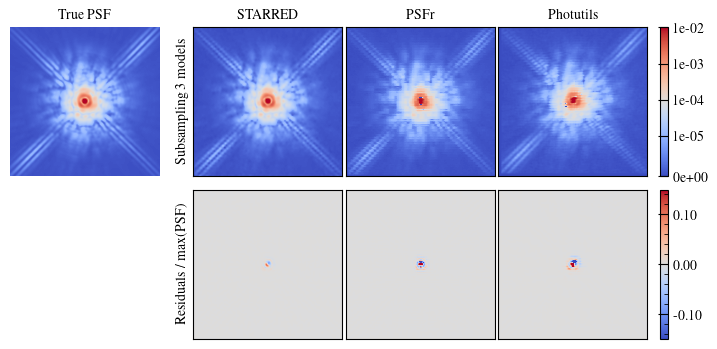

Mean Absolute Error STARRED(subsampling 3) : 3.7660196409124494e-06
Mean Absolute Error PSFr (subsampling 3) : 1.2506267731491164e-05
Mean Absolute Error Photutils (subsampling 3) : 1.7014066507003863e-05
MAE ratio PSFr/STARRED : 3.3208185097146985
MAE ratio Photutils/STARRED : 4.517784857564262


In [6]:
### recovering the PSF : 
PSF_retrieved = fits.open(os.path.join(outputpath, 'full_PSF.fits'))[0].data
PSF_truth = fits.open(os.path.join('./data/6_data/PSF/', 'psf_tinytim_size59_upsampling%i.fits'%subsampling))[0].data
PSF_truth /= np.sum(PSF_truth)


# plot params for paper
plt.rcParams['axes.labelsize']= 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize']= 10
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.top']= True
plt.rcParams['xtick.minor.visible']=  True
plt.rcParams['xtick.major.size']=  7
plt.rcParams['xtick.minor.size']=  3
plt.rcParams['ytick.labelsize']=  10
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.right']=  True
plt.rcParams['ytick.minor.visible']=  True
plt.rcParams['ytick.major.size']=  7
plt.rcParams['ytick.minor.size']=  3
plt.rcParams['legend.numpoints']=  1
plt.rcParams['legend.facecolor']=  'None'
plt.rcParams['legend.edgecolor']=  'None'
plt.rcParams['legend.fontsize']=  10
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'
plt.rcParams["image.cmap"] = "coolwarm"


# the figure
fig_width = 8.5 # in inches
fig_height = fig_width / 2.1
fig = plt.figure(figsize=(fig_width, fig_height))

ratio = 5
firstplotsep = 3
colorbarsep = 2
gs = gridspec.GridSpec(3, ratio*12 + firstplotsep + colorbarsep, height_ratios=[1,-0.1, 1])
# +5 : 3 for first plot, 2 for color bar including a padding of 1

# truth plot
ax = fig.add_subplot(gs[0, :ratio*3])
ax.set_title(f'True PSF')
img = ax.imshow(PSF_truth, norm=colors.SymLogNorm(linthresh=0.00001, vmin=0, vmax=0.01), origin='lower')
ax.axis('off')
# psf models plots
for i in range(1, 4):
    ax = fig.add_subplot(gs[0, ratio*3*i+firstplotsep:ratio*(3*(i+1))+firstplotsep])
    psf_data = [PSF_truth, PSF_retrieved, psf_psfr, PSF_photutils][i]
    title = ['', 'STARRED', 
             'PSFr', 'Photutils'][i]
    ax.set_title(f'{title}')
    img = ax.imshow(psf_data, norm=colors.SymLogNorm(linthresh=0.00001, vmin=0, vmax=0.01), origin='lower')
    if i == 1:
        ax.set_ylabel(f'Subsampling {subsampling} models')
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# add single colorbar to the right
cax = fig.add_subplot(gs[0, -1:])
fig.colorbar(img, cax=cax, fraction=0.046, pad=0.04, format='%.0e')
#cax.get_yaxis().set_visible(False)

# residuals
for i in range(1,4):
    ax = fig.add_subplot(gs[2, firstplotsep+ratio*3*i:firstplotsep+ratio*(3*(i+1))])

    residual_data = [[], (PSF_truth - PSF_retrieved)/np.max(PSF_truth), 
                     (PSF_truth - psf_psfr)/np.max(PSF_truth), 
                     (PSF_truth - PSF_photutils)/np.max(PSF_truth)][i]
    title = ['', 'STARRED', 'PSFr', 'Photutils'][i]

    img = ax.imshow(residual_data, origin='lower', vmin=-0.149, vmax=0.149)

    if i == 1:
        ax.set_ylabel('Residuals / max(PSF)')
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
# single colorbar to the right again
cax = fig.add_subplot(gs[2, -1:])
fig.colorbar(img, cax=cax, fraction=0.046, pad=0.04, format='%2.2f')



plt.subplots_adjust(wspace=0.3, hspace=0.15)
plt.savefig('output_PSF_HST/plot_PSF_HST.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

MAE_STARRED = np.mean(np.abs(PSF_truth - PSF_retrieved))
MAE_PSFR = np.mean(np.abs(PSF_truth - psf_psfr))
MAE_photutils = np.mean(np.abs(PSF_truth - PSF_photutils))

print('Mean Absolute Error STARRED(subsampling %i) :'%subsampling, MAE_STARRED)
print('Mean Absolute Error PSFr (subsampling %i) :'%subsampling, MAE_PSFR)
print('Mean Absolute Error Photutils (subsampling %i) :'%subsampling, MAE_photutils)

print('MAE ratio PSFr/STARRED :', MAE_PSFR/ MAE_STARRED)
print('MAE ratio Photutils/STARRED :', MAE_photutils/ MAE_STARRED)
